# ML pipeline to optimize goal and budget

Given an _action type_ sequence of counts and transition probabilities, of a goal at time t, what is the probability that the _spend amount_ will result in filling the expected _action type_ counts at time t+1, t+2, ... ?


In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True


In [2]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
import tensorflow_probability as tfp
import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
from mining.modules.budget.optimization import predGoalSpend as gs
from mining.modules.budget.optimization import __propAttr__ as pr
from rezaware.modules.etl.loader import sparkFile as file

''' restart initiate classes '''
if debug:
    import importlib
    pr = importlib.reload(pr)
    gs = importlib.reload(gs)
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "read and write BigQuery dataset for hypothese testing"

clsFile = file.dataWorkLoads(
    desc = __desc__,
    store_mode='local-fs',
    store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
clsGS = gs.adBudgetMLWorkLoads(desc = __desc__)

print("\n%s class initialization and load complete!" % __desc__)

2025-02-22 11:15:51.290473: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-22 11:15:53.153697: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-22 11:15:54.370371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740194155.404049 1086596 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740194155.677257 1086596 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 11:15:57.408367: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

All functional __PROPATTR__-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional PREDGOALSPEND-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional __PROPATTR__-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
All functional __PROPATTR__-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional PREDGOALSPEND-libraries in OPTIMIZATION-package of BUDGET-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
All functional APP-libraries in REZAWARE-package of REZAWARE-module imported successfully!
__propAttr__ Class initialization complete
sparkFile Class initialization complete
__propAttr__ Class initialization complete
predGoalSpend Class initialization complete

read and write BigQuery dataset for hypothese testing c

## Read data

In [4]:
from pyspark.sql.functions import unix_timestamp

options = {
    "inferSchema":True,
    "header":True,
    "delimiter":",",
    "pathGlobFilter":'*.csv',
    "recursiveFileLookup":True,
}

sdf=clsFile.read_files_to_dtype(
    as_type = "SPARK",      # optional - define the data type to return
    folder_path="mining/data/budget/",  # optional - relative path, w.r.t. self.storeRoot
    file_name="complete-60-accounts.csv",  # optional - name of the file to read
    file_type=None,  # optional - read all the files of same type
    **options,
)
print("Loaded %d rows" % sdf.count())

sdf = sdf.withColumn('date', unix_timestamp('updated_time'))

### USE python currency-converter librabry with date
sdf = sdf.withColumn(
    "spend_usd",
    F.when(F.col('account_currency').isin('CAD'), F.col('spend') * 0.70)
     .when(F.col('account_currency').isin('EUR'), F.col('spend') * 1.05)
     .when(F.col('account_currency').isin('THB'), F.col('spend') * 0.03)
     .when(F.col('account_currency').isin('INR'), F.col('spend') * 0.012)
     .when(F.col('account_currency').isin('USD'), F.col('spend') * 1.00)
     .otherwise(F.col('spend') * 1.00)
)
print('Converted spend to usd')
# print(sdf.printSchema())

25/02/22 11:18:54 WARN Utils: Your hostname, Waidy-Think-Three resolves to a loopback address: 127.0.1.1; using 192.168.2.82 instead (on interface enp0s25)
25/02/22 11:18:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/02/22 11:18:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
                                                                                

Loaded 61513 rows
Converted spend to usd


In [5]:
sdf.groupBy(F.col('goal'), F.col('account_currency')).count()\
    .orderBy(F.col('goal')).show(truncate=False)

+-----------------------------+----------------+-----+
|goal                         |account_currency|count|
+-----------------------------+----------------+-----+
|IMPRESSIONS                  |THB             |1    |
|LINK_CLICKS                  |USD             |17   |
|MESSAGING_PURCHASE_CONVERSION|THB             |269  |
|MESSAGING_PURCHASE_CONVERSION|USD             |1    |
|OFFSITE_CONVERSIONS          |INR             |34681|
|OFFSITE_CONVERSIONS          |EUR             |205  |
|OFFSITE_CONVERSIONS          |CAD             |5200 |
|OFFSITE_CONVERSIONS          |USD             |16223|
|POST_ENGAGEMENT              |THB             |2    |
|REACH                        |THB             |1    |
|REACH                        |USD             |32   |
|REPLIES                      |THB             |417  |
|REPLIES                      |CAD             |4040 |
|RETURN_ON_AD_SPEND           |USD             |82   |
|RETURN_ON_AD_SPEND           |INR             |342  |
+---------

In [6]:
__def_geom__ = 'NYC,USA'
__def_demog__= [{"age":'35-55', "male": 0.60, "female": 0.37, "unknown": 0.03}]
__def_goal__ = 'OFFSITE_CONVERSIONS'
__def_model_name__="_".join([__def_goal__,])
''' wihout updated_time', 'spend_usd', 'impressions', 'click', 'reach', 'frequency '''
_goal_df= sdf.select('date','spend_usd', 'impressions', 'click', 'reach', 'frequency')\
            .where(F.col('goal').isin(__def_goal__)) \
            .dropna().orderBy('updated_time').toPandas()

print("data shape:", _goal_df.shape)
print("some stats:\n", _goal_df.describe())

data shape: (56309, 6)
some stats:
                date     spend_usd   impressions          click         reach  \
count  5.630900e+04  56309.000000  5.630900e+04   56309.000000  5.630900e+04   
mean   1.730340e+09     29.966158  7.318835e+03     306.342166  6.316045e+03   
std    5.082494e+06     96.009231  2.551094e+04    1856.726374  2.181607e+04   
min    1.696262e+09      0.000000  0.000000e+00       0.000000  0.000000e+00   
25%    1.726502e+09      0.840840  1.810000e+02       4.000000  1.530000e+02   
50%    1.730909e+09      4.980720  1.394000e+03      32.000000  1.186000e+03   
75%    1.734451e+09     18.213720  5.682000e+03     144.000000  4.761000e+03   
max    1.738858e+09   5152.530000  1.873861e+06  165274.000000  1.506747e+06   

          frequency  
count  56309.000000  
mean       0.987710  
std        0.463990  
min        0.000000  
25%        1.051282  
50%        1.116855  
75%        1.203747  
max        3.500000  


In [9]:
from sklearn.model_selection import train_test_split

__def_spend_col_name__='spend_usd'
__feature_col_lst__ = ['date', 'impressions', 'click', 'reach', 'frequency']

X = np.array(_goal_df[__feature_col_lst__])
y = np.array(_goal_df[__def_spend_col_name__])             

print("X: ",X.shape,"y: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print("X_train: ",X_train.shape, "y_train: ", y_train.shape,
      "\nX_test: ", X_test.shape, "y_test: ", y_test.shape)

X:  (56309, 5) y:  (56309,)
X_train:  (45047, 5) y_train:  (45047,) 
X_test:  (11262, 5) y_test:  (11262,)


### XGBoost Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor as gbr

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = gbr(**params)
reg.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

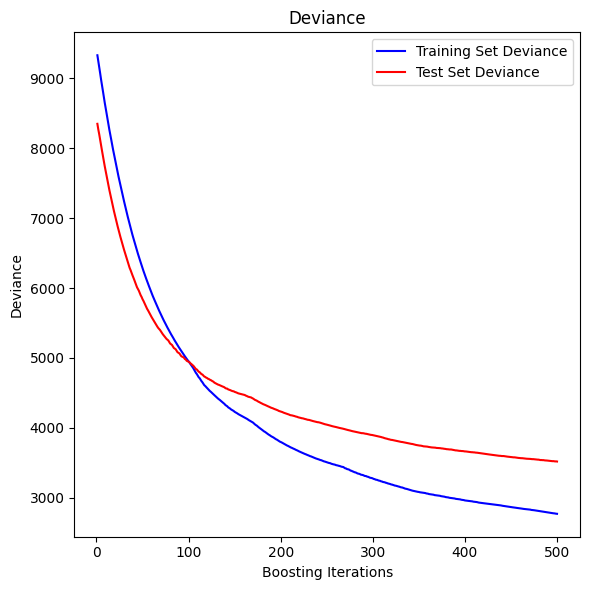

In [13]:
import matplotlib.pyplot as plt

test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

### Clustering

In [ ]:
# add cluster labels to X
from sklearn.cluster import KMeans, DBSCAN

clustering_ = KMeans(n_clusters = 3).fit(X)
# clustering_ = DBSCAN().fit(X)
X = np.append(X, clustering_.labels_.reshape(-1,1), 1)


## Train and Validate model

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# __def_spend_col_name__='spend_usd'
# __feature_col_lst__ = ['CPC', 'CPM', 'CTR', 'ROAS', 
#                        'impressions', 'click', 'reach', 'frequency']

In [14]:
from sklearn.ensemble import GradientBoostingRegressor as gbr

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
# reg = gbr(**params)
# reg.fit(X_train, y_train)

pipe = Pipeline([
    ('transformer', StandardScaler()),   # best compared to MinMaxScaler or Polynomial Feature
    # ('reduction', PCA(n_components=2)),  # PCA reduction doesn't improve scores
    ('numerical_imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    # ('trained_model', ExtraTreesRegressor(n_estimators=200, random_state=0)),
    ('trained_model', gbr(**params)),
])
pipe.fit(
    X_train, #.reshape(-1,len(__feature_col_lst__)),
    y_train, #.reshape(-1,1)
    )
print("Completed model fit", pipe)

Completed model fit Pipeline(steps=[('transformer', StandardScaler()),
                ('numerical_imputer', SimpleImputer()),
                ('trained_model',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=4,
                                           min_samples_split=5,
                                           n_estimators=500))])


### Cross validation scores

In [15]:
scores = cross_val_score(pipe, X, y, cv=10)
print("Score mean: %0.2f and stdv: %0.2f" % (scores.mean(), scores.std()))

Score mean: 0.23 and stdv: 0.18


### Prediction

In [16]:
# y_pred = pipe.predict(X_test)
y_pred = pipe.predict(X_test)
print("Prediction complete shape:", y_pred.shape)
# print scores
print('MAE',mean_absolute_error(y_test, y_pred))
print('RMSE',root_mean_squared_error(y_test, y_pred))

Prediction complete shape: (11262,)
MAE 22.743067996252165
RMSE 59.830937737701696
